In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import yfinance as yf
from Classes import Data
from Classes import Sortino

2025-02-28 10:31:32.832859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# CPO

### Carga de datos

In [2]:
data = Data()
data.dates("2024-01-01", "2025-01-01")
data.sp500()
df_prices = data.prices()
df_random = data.random(df_prices, num=15)
df_rend = data.returns(df_random)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
pd.read_csv('rfr.csv')

,Date,rfr
0,2010-01-01,0.02
1,2010-02-01,0.06
2,2010-03-01,0.12
3,2010-04-01,0.15
4,2010-05-01,0.15
...,...,...
176,2024-09-01,5.06
177,2024-10-01,4.92
178,2024-11-01,4.71
179,2024-12-01,4.50


### Sortino Data Frame

In [4]:
sortino = Sortino(returns_df=df_rend,rfr_csv_path="rfr.csv")
sortino.generate_multiple_weights()
sortino.calculate_portfolio_returns()
sortino.calculate_sortino_ratio()

Generadas 1000 combinaciones de pesos para cada fecha.
Rendimientos del portafolio calculados para cada combinación de pesos.
Ratios de Sortino calculados para cada combinación de pesos.


In [5]:
dfsortino = sortino.create_portfolio_dataset()
dfsortino

,Date,"Weight_('BKR', 'BKR')","Weight_('CARR', 'CARR')","Weight_('CBOE', 'CBOE')","Weight_('APD', 'APD')","Weight_('AMAT', 'AMAT')","Weight_('ABBV', 'ABBV')","Weight_('AMCR', 'AMCR')","Weight_('BALL', 'BALL')","Weight_('BG', 'BG')","Weight_('CE', 'CE')","Weight_('CDW', 'CDW')","Weight_('APO', 'APO')","Weight_('AEE', 'AEE')","Weight_('AXON', 'AXON')","Weight_('ADSK', 'ADSK')",Portfolio_Returns,Sortino_Ratio
0,2024-02-29,0.770756,1.096436,12.467811,8.554360,2.381410,4.584651,5.417115,6.608987,12.082591,10.002915,5.592289,10.093444,4.374767,5.774035,10.198434,0.063646,2.507721
1,2024-02-29,1.685795,9.577276,4.229595,5.583120,11.138006,7.676022,3.584101,6.999386,5.440038,4.358797,12.082458,10.762337,7.010049,2.241064,7.631954,0.078351,3.089140
2,2024-02-29,10.345622,7.358069,6.706845,5.885987,5.730213,4.956391,10.352956,6.744275,9.302379,5.117677,1.223243,8.482982,4.624682,5.079771,8.088908,0.063572,2.504825
3,2024-02-29,7.227813,5.883591,7.587446,4.253699,6.808675,2.154107,10.191229,9.607427,2.884196,4.657984,4.056829,9.179341,11.675136,3.957621,9.874908,0.066108,2.605067
4,2024-02-29,0.861008,2.254996,8.322465,2.001608,12.970502,3.743681,3.335175,9.220174,4.582174,16.997849,5.339484,9.633567,16.253700,3.600997,0.882620,0.088353,3.484565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,2024-12-31,5.699717,10.586625,2.520756,3.956362,6.850653,5.867822,15.531830,12.345012,10.405949,0.847839,0.487025,2.320194,12.516482,6.064727,3.999007,-0.087791,-3.478008
10996,2024-12-31,7.117452,5.086333,7.186961,2.006598,10.962459,7.101986,3.552082,11.039733,9.268521,14.943499,6.372562,10.046410,0.817769,1.848994,2.648641,-0.074392,-2.948275
10997,2024-12-31,1.849713,9.722943,10.108814,3.678189,2.813333,9.837847,2.755398,4.502111,7.960130,6.882439,9.493978,9.494791,8.810795,2.345464,9.744053,-0.065476,-2.595777
10998,2024-12-31,10.736120,8.528414,5.009879,4.309402,11.278512,6.593680,12.567553,1.754327,6.208823,6.825058,3.478448,1.844533,4.166732,12.351612,4.346906,-0.078507,-3.110956


In [4]:
dataset_merged = pd.read_csv('Data_Base/dataset_merged.csv')
sampling_data = pd.read_csv('Sampling_data.csv')

In [6]:
dataset_merged.describe()

,Unnamed: 0,"Weight_('BALL', 'BALL')","Weight_('BSX', 'BSX')","Weight_('CZR', 'CZR')","Weight_('AEP', 'AEP')","Weight_('ARE', 'ARE')","Weight_('ABT', 'ABT')","Weight_('BLDR', 'BLDR')","Weight_('GOOG', 'GOOG')","Weight_('MO', 'MO')",...,WTI index,Dollar index,TRCCRB,BCI,CCI,CLI,GPRI,Unemployment rate,Portfolio_Returns,Sortino_Ratio
count,179000.00000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,...,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,179000.000000,123000.000000,123000.000000
mean,89499.50000,6.659674,6.658353,6.665573,6.669224,6.656715,6.682044,6.670020,6.662237,6.671269,...,0.005698,0.002291,0.001006,100.222772,99.545419,100.222772,2.295196,5.775978,0.014439,0.439851
std,51672.99343,3.844111,3.841827,3.842968,3.838186,3.847300,3.843388,3.839821,3.843072,3.839530,...,0.116004,0.021554,0.047697,0.883412,1.106564,0.883412,0.740032,2.216635,0.048961,1.498609
min,0.00000,0.000028,0.000123,0.000492,0.000045,0.000047,0.000046,0.000080,0.000031,0.000050,...,-0.540000,-0.050000,-0.240000,96.761450,96.624510,96.761450,1.250000,3.400000,-0.242180,-7.414095
25%,44749.75000,3.446605,3.445169,3.443461,3.462400,3.429395,3.473962,3.457859,3.444670,3.450228,...,-0.060000,-0.010000,-0.030000,99.582950,98.877400,99.582950,1.760000,3.900000,-0.013353,-0.410358
50%,89499.50000,6.654430,6.645424,6.670457,6.661126,6.646412,6.671420,6.673814,6.654035,6.687503,...,0.010000,0.000000,0.000000,100.177400,99.504150,100.177400,2.110000,5.000000,0.017690,0.539749
75%,134249.25000,9.679254,9.670872,9.685147,9.675801,9.660931,9.704938,9.682952,9.684421,9.685547,...,0.060000,0.020000,0.030000,100.784900,100.514900,100.784900,2.690000,7.500000,0.045073,1.377038
max,178999.00000,27.155056,24.022641,27.838829,27.137399,26.216470,23.993981,26.728226,24.021959,24.479848,...,0.880000,0.070000,0.130000,102.061700,101.183400,102.061700,6.900000,14.800000,0.246018,7.531536


In [11]:
sampling_data.describe()

,Unnamed: 0,"Weight_('BALL', 'BALL')","Weight_('BSX', 'BSX')","Weight_('CZR', 'CZR')","Weight_('AEP', 'AEP')","Weight_('ARE', 'ARE')","Weight_('ABT', 'ABT')","Weight_('BLDR', 'BLDR')","Weight_('GOOG', 'GOOG')","Weight_('MO', 'MO')",...,WTI index,Dollar index,TRCCRB,BCI,CCI,CLI,GPRI,Unemployment rate,Portfolio_Returns,Sortino_Ratio
count,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,36200.000000,...,36200.00,36200.00,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,3.620000e+04,36200.000000,36200.000000
mean,56090.000000,6.877998,6.893875,6.347055,6.395892,6.544488,6.923403,6.567539,6.371105,6.522182,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.050068,1.532788
std,52.250124,3.826923,3.642740,3.901985,3.884581,4.004338,3.490745,3.818005,3.954274,4.012539,...,0.00,0.00,1.110238e-16,1.421105e-14,2.842210e-14,1.421105e-14,2.220477e-16,1.776381e-15,0.010014,0.306581
min,56000.000000,0.114853,0.076915,0.038760,0.012865,0.036449,0.054632,0.028081,0.018887,0.063588,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.024527,0.750871
25%,56045.000000,3.881524,4.098672,2.836147,3.260928,2.877356,4.304482,3.353213,2.793953,3.380585,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.043295,1.325445
50%,56090.000000,6.591996,6.964783,6.082038,6.497772,7.212210,7.394765,6.388311,6.533260,6.732725,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.050423,1.543656
75%,56135.000000,9.853152,9.512524,9.670696,9.039570,9.448945,9.634104,9.668159,9.611395,9.837269,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.056935,1.743041
max,56180.000000,15.960789,16.853355,15.300434,21.330791,17.769886,14.629643,18.376732,19.554063,19.954894,...,-0.54,0.01,-2.400000e-01,1.005164e+02,1.000032e+02,1.005164e+02,1.770000e+00,5.700000e+00,0.075765,2.319502


# Training ML models

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# For models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from Classes import BasePortfolioModel, LinearRegressionModel, NeuralNetworkModel, XGBoostModel, SVRModel

Training Linear Regression Model...
Linear Regression model fitted.
Evaluation -- MSE: 1.6632, R2: 0.2599

Training Neural Network Model...


/Users/alexsotomayor/code/PAP/New_CPO/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network model trained.
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluation -- MSE: 0.0410, R2: 0.9818

Training SVR Model...
SVR model fitted.
Evaluation -- MSE: 1.8244, R2: 0.1882

Training XGBoost Model...
XGBoost model fitted.
Evaluation -- MSE: 0.3220, R2: 0.8567
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


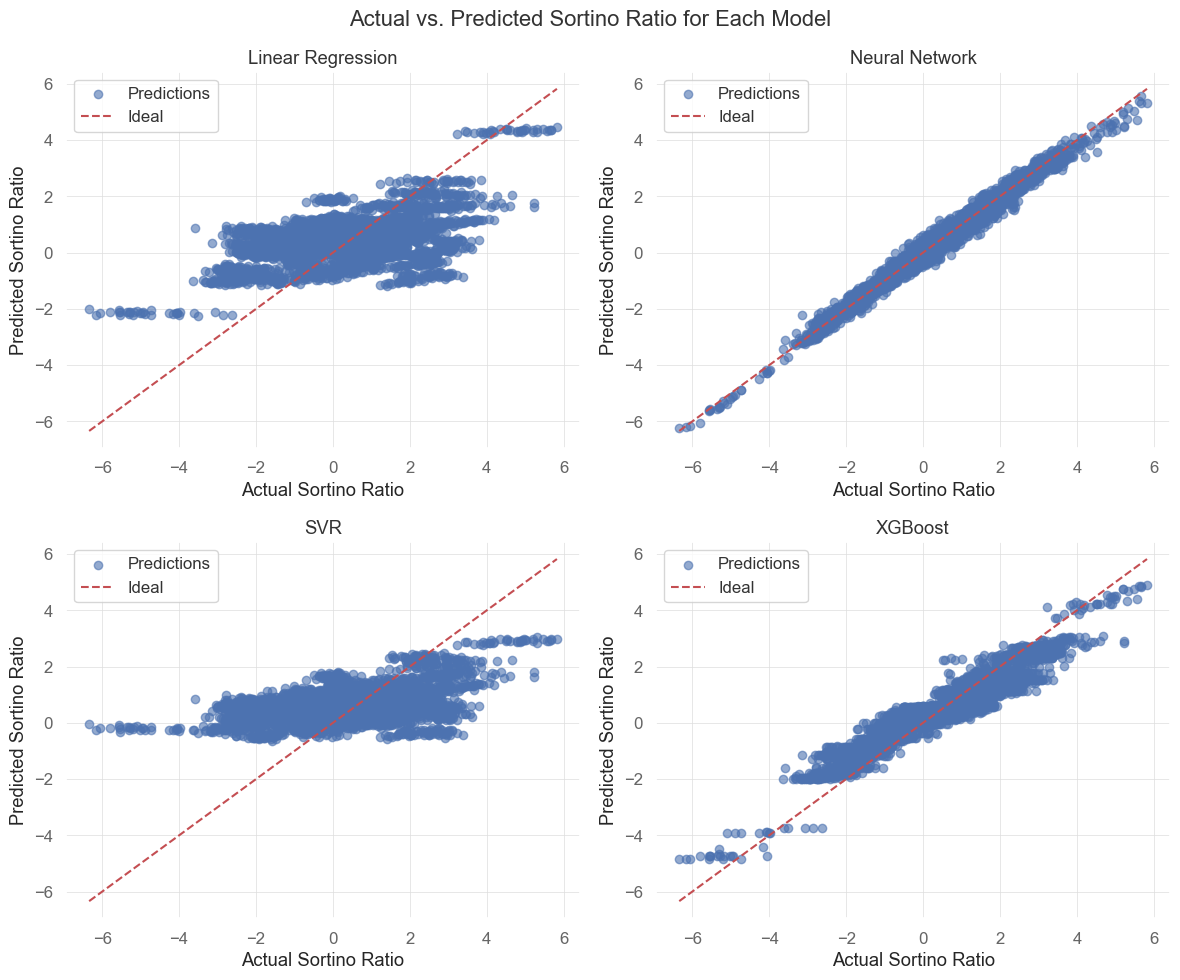

In [28]:
def plot_model_results(models, X_test, y_test):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for ax, (name, model) in zip(axes, models.items()):
        preds = model.predict(X_test)
        ax.scatter(y_test, preds, alpha=0.6, label='Predictions')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
        ax.set_xlabel("Actual Sortino Ratio")
        ax.set_ylabel("Predicted Sortino Ratio")
        ax.set_title(name)
        ax.legend()

    fig.suptitle("Actual vs. Predicted Sortino Ratio for Each Model")
    plt.tight_layout()
    plt.show()


def main():
    # Cargar datos
    df = pd.read_csv('sampled_data.csv')
    
    # Dividir entre X e y
    X = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    
    # Train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models = {}
    
    print("Training Linear Regression Model...")
    lr_model = LinearRegressionModel()
    lr_model.fit(X_train, y_train)
    lr_model.evaluate(X_test, y_test)
    models["Linear Regression"] = lr_model
    
    print("\nTraining Neural Network Model...")
    nn_model = NeuralNetworkModel(input_dim=X.shape[1], hidden_units=64, epochs=100)
    nn_model.fit(X_train, y_train)
    nn_model.evaluate(X_test, y_test)
    models["Neural Network"] = nn_model
    
    print("\nTraining SVR Model...")
    svr_model = SVRModel(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    svr_model.evaluate(X_test, y_test)
    models["SVR"] = svr_model
    
    print("\nTraining XGBoost Model...")
    xgb_model = XGBoostModel(n_estimators=100, max_depth=4, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    xgb_model.evaluate(X_test, y_test)
    models["XGBoost"] = xgb_model

    # Graficar resultados para mejor visualización
    plot_model_results(models, X_test, y_test)
    

if __name__ == "__main__":
    main()